In [656]:
import numpy as np
import pandas as pd
import functions as func
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import export_text
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline

db_locations = func.import_yaml()

#load df
df_raw = pd.read_csv(db_locations['data_clean']['train'])
df = pd.read_csv(db_locations['data_clean']['train_merged'])

#### Data Cleaning
We used the cleaned data: db_locations['data_clean']['train_merged']

In [673]:
df_raw.columns

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

In [657]:
df = df.drop(df.filter(like='brand_', axis=1).columns, axis=1)

#### Feature Engineering

In [658]:
# One-hot encoding for ext_col', 'int_col'
df = pd.get_dummies(df, columns=['ext_col', 'int_col'])

In [659]:
mean_price_by_brand = df_raw.groupby('brand')[['price']].mean().reset_index().sort_values(by='price', ascending=False)
mean_price_by_brand['brand_ratio'] = mean_price_by_brand['price']/mean_price_by_brand.iloc[-1,-1]

In [660]:
brand_id = df_raw[['id','brand']]

In [661]:
brand_id = brand_id.merge(mean_price_by_brand[['brand', 'brand_ratio']], on='brand', how='left')

In [662]:
df = df.merge(brand_id, on='id', how='left')

#### Feature Selection

Predictors:
- brand: 57 brands: Ford (12%), Merc (10%), BMW (9%), Chev (8%)
- model 
- model_year (numerical)
- milage (numerical)
- fuel_type: Diesel, Electric, Gasoline, Hybrid
- engine
    - horsepower (numerical)
    - engine_size (numerical)
    - cylinders (numerical)
- transmission: Automatic, CVT, Manual, Other
- ext_col: 16 colors: Black, White, Gray, Silver, etc
- int_col: 13 colors: Black, Beige, Gray, etc
- accident (dummy)
- clean_title (dummy)

Target:
- price

In [663]:
# Create correlation matrix
corr_matrix=np.abs(df.corr()) # corr(x,y) = corr(y, x), corr(x,x) = 1

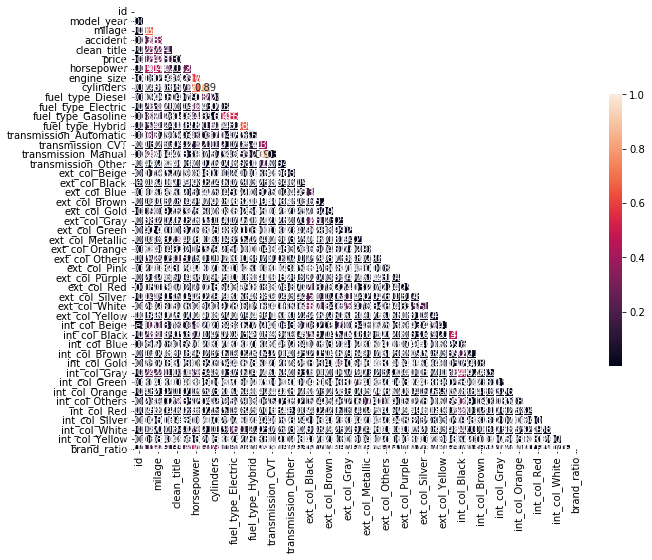

In [667]:
#Set up mask for triangle representation
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr_matrix)

plt.show()

In [664]:
threshold = 0.5

# Create a mask to avoid duplicate pairs (since the matrix is symmetric)
# Only keep the upper triangle of the matrix
upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

# Apply the mask to the correlation matrix and filter based on the threshold
filtered_corr = corr_matrix.where(upper_triangle)  # Keep upper triangle

# Find pairs with correlation higher than the threshold
high_corr_pairs = filtered_corr.stack().reset_index()

# Rename the columns for clarity
high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Filter the pairs based on the threshold
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'].abs() > threshold]

In [665]:
high_corr_pairs.sort_values(by='Correlation', ascending=False)

,Feature 1,Feature 2,Correlation
521,transmission_Automatic,transmission_Manual,0.900829
301,engine_size,cylinders,0.886290
262,horsepower,cylinders,0.697639
46,model_year,milage,0.675361
451,fuel_type_Gasoline,fuel_type_Hybrid,0.654406
261,horsepower,engine_size,0.605292
415,fuel_type_Electric,fuel_type_Gasoline,0.536552


In [676]:
# Checking features which has high correlation with Price
corr_matrix["price"].sort_values(ascending=False).head(10)

price             1.000000
milage            0.284189
horsepower        0.276135
model_year        0.236145
brand_ratio       0.214266
cylinders         0.132266
accident          0.125423
engine_size       0.096972
clean_title       0.089867
ext_col_Others    0.074695
Name: price, dtype: float64

In [597]:
df.dropna(inplace=True)

#### Train Test Split

In [598]:
features = df[['brand_ratio','model_year','milage','horsepower','fuel_type_Gasoline','transmission_Automatic','ext_col_Silver','int_col_Beige','accident','clean_title']]
target = df['price']

In [390]:
#features = df[['model_year','milage','horsepower','fuel_type_Gasoline','transmission_Automatic','accident','clean_title']]
#target = df['price']

In [599]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=0)

#### Normalization

In [600]:
normalizer = MinMaxScaler()
normalizer.fit(x_train)
x_train_norm = normalizer.transform(x_train)
x_test_norm = normalizer.transform(x_test)

In [601]:
x_train_norm = pd.DataFrame(x_train_norm, columns = x_train.columns)
x_test_norm = pd.DataFrame(x_test_norm, columns = x_test.columns)

#### Regression Model & Evaluation
- KNN Regression (Aisyah)
- Linear Regression (Aisyah)
- Decision Trees (Paola)
- Bagging and Pasting (Paola)
- Random Forest (Flory)
- Gradient Boosting (Flory)
- Adaptive Boosting (Paola)

**KNN Regression**

In [250]:
knn5 = KNeighborsRegressor(n_neighbors=5)
knn5.fit(x_train, y_train)
pred = knn5.predict(x_train)
print("MAE", round(mean_absolute_error(pred, y_train),2))
print("RMSE", round(mean_squared_error(pred, y_train, squared=False),2))
print(f"R2: {knn5.score(x_train, y_train): .2f}")

MAE 15343.22642271021
RMSE 54536.190173016235
R2:  0.35


In [251]:
pred = knn5.predict(x_test)
print("MAE", round(mean_absolute_error(pred, y_test),2))
print("RMSE", round(mean_squared_error(pred, y_test, squared=False),2))
print(f"R2: {knn5.score(x_test, y_test): .2f}")

MAE 18736.61541425819
RMSE 68115.88078192051
R2:  0.01


In [252]:
knn8 = KNeighborsRegressor(n_neighbors=8)
knn8.fit(x_train, y_train)
pred = knn8.predict(x_train)
print("MAE", round(mean_absolute_error(pred, y_train),2))
print("RMSE", round(mean_squared_error(pred, y_train, squared=False),2))
print(f"R2: {knn8.score(x_train, y_train): .2f}")

MAE 16235.936362164048
RMSE 57577.9527119675
R2:  0.27


In [253]:
pred = knn8.predict(x_test)
print("MAE", round(mean_absolute_error(pred, y_test),2))
print("RMSE", round(mean_squared_error(pred, y_test, squared=False),2))
print(f"R2: {knn8.score(x_test, y_test): .2f}")

MAE 18447.614739053883
RMSE 66724.60583957477
R2:  0.05


In [254]:
knn10 = KNeighborsRegressor(n_neighbors=10)
knn10.fit(x_train, y_train)
pred = knn10.predict(x_train)
print("MAE", round(mean_absolute_error(pred, y_train),2))
print("RMSE", round(mean_squared_error(pred, y_train, squared=False),2))
print(f"R2: {knn10.score(x_train, y_train): .2f}")

MAE 16488.86688316003
RMSE 58476.61960234941
R2:  0.25


In [255]:
pred = knn10.predict(x_test)
print("MAE", round(mean_absolute_error(pred, y_test),2))
print("RMSE", round(mean_squared_error(pred, y_test, squared=False),2))
print(f"R2: {knn10.score(x_test, y_test): .2f}")

MAE 18270.39
RMSE 65993.76
R2:  0.07


In [602]:
knn10 = KNeighborsRegressor(n_neighbors=10)
knn10.fit(x_train_norm, y_train)
pred = knn10.predict(x_train_norm)
print("MAE", round(mean_absolute_error(pred, y_train),2))
print("RMSE", round(mean_squared_error(pred, y_train, squared=False),2))
print(f"R2: {knn10.score(x_train_norm, y_train): .2f}")

MAE 16183.32
RMSE 58457.25
R2:  0.25


In [603]:
pred = knn10.predict(x_test_norm)
print("MAE", round(mean_absolute_error(pred, y_test),2))
print("RMSE", round(mean_squared_error(pred, y_test, squared=False),2))
print(f"R2: {knn10.score(x_test_norm, y_test): .2f}")

MAE 17628.06
RMSE 65764.58
R2:  0.08


**Linear Regression**

In [604]:
lin_reg = LinearRegression()
lin_reg.fit(x_train_norm, y_train)
pred = lin_reg.predict(x_train_norm)
print("MAE", round(mean_absolute_error(pred, y_train),2))
print("RMSE", round(mean_squared_error(pred, y_train, squared=False),2))
print("R2", round(lin_reg.score(x_train_norm, y_train),2))

MAE 19194.52
RMSE 63131.62
R2 0.13


In [605]:
lin_reg = LinearRegression()
lin_reg.fit(x_test_norm, y_test)
pred = lin_reg.predict(x_test_norm)
print("MAE", round(mean_absolute_error(pred, y_test),2))
print("RMSE", round(mean_squared_error(pred, y_test, squared=False),2))
print("R2", round(lin_reg.score(x_test_norm, y_test),2))

MAE 19068.93
RMSE 63974.5
R2 0.13


In [606]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
pred = lin_reg.predict(x_train)
print("MAE", round(mean_absolute_error(pred, y_train),2))
print("RMSE", round(mean_squared_error(pred, y_train, squared=False),2))
print("R2", round(lin_reg.score(x_train, y_train),4))

MAE 19194.52
RMSE 63131.62
R2 0.1257


In [607]:
lin_reg = LinearRegression()
lin_reg.fit(x_test, y_test)
pred = lin_reg.predict(x_test)
print("MAE", round(mean_absolute_error(pred, y_test),2))
print("RMSE", round(mean_squared_error(pred, y_test, squared=False),2))
print("R2", round(lin_reg.score(x_test, y_test),4))

MAE 19068.93
RMSE 63974.5
R2 0.1252


In [608]:
lin_reg_coef = {feature : coef for feature, coef in zip(x_train.columns, lin_reg.coef_)}
lin_reg_coef

{'brand_ratio': 5444.830984390476,
 'model_year': 785.1662454788162,
 'milage': -0.23873507972461994,
 'horsepower': 82.17960878605591,
 'fuel_type_Gasoline': -3391.4805316889024,
 'transmission_Automatic': -1346.197339394644,
 'ext_col_Silver': -3068.106935562033,
 'int_col_Beige': -1458.3745861476818,
 'accident': -3546.781547464701,
 'clean_title': -10308.179826007363}

In [609]:
est = sm.OLS(y_train, x_train)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.342
Model:                            OLS   Adj. R-squared (uncentered):              0.342
Method:                 Least Squares   F-statistic:                              6266.
Date:                Thu, 19 Sep 2024   Prob (F-statistic):                        0.00
Time:                        17:24:35   Log-Likelihood:                     -1.5018e+06
No. Observations:              120404   AIC:                                  3.004e+06
Df Residuals:                  120394   BIC:                                  3.004e+06
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

**Decision Trees**

In [610]:
tree = DecisionTreeRegressor(max_depth=5)
tree.fit(x_train_norm, y_train)

DecisionTreeRegressor(max_depth=5)

In [611]:
pred = tree.predict(x_train_norm)

print(f"MAE, {mean_absolute_error(pred, y_train): .2f}")
print(f"RMSE, {mean_squared_error(pred, y_train, squared=False): .2f}")
print(f"R2 score, {tree.score(x_train_norm, y_train): .2f}")

MAE,  17033.61
RMSE,  62159.81
R2 score,  0.15


In [612]:
pred = tree.predict(x_test_norm)

print(f"MAE, {mean_absolute_error(pred, y_test): .2f}")
print(f"RMSE, {mean_squared_error(pred, y_test, squared=False): .2f}")
print(f"R2 score, {tree.score(x_test_norm, y_test): .2f}")

MAE,  16933.76
RMSE,  63331.70
R2 score,  0.14


In [613]:
tree_importance = {feature : importance for feature, importance in zip(x_train_norm.columns, tree.feature_importances_)}
tree_importance

{'brand_ratio': 0.043296612630079286,
 'model_year': 0.048677050616528446,
 'milage': 0.7544395506400697,
 'horsepower': 0.1437062253541146,
 'fuel_type_Gasoline': 0.0,
 'transmission_Automatic': 0.009880560759207796,
 'ext_col_Silver': 0.0,
 'int_col_Beige': 0.0,
 'accident': 0.0,
 'clean_title': 0.0}

In [614]:
tree_viz = export_text(tree, feature_names=list(x_train_norm.columns))
print(tree_viz)

|--- milage <= 0.09
|   |--- horsepower <= 0.54
|   |   |--- milage <= 0.03
|   |   |   |--- brand_ratio <= 0.21
|   |   |   |   |--- model_year <= 0.97
|   |   |   |   |   |--- value: [62003.03]
|   |   |   |   |--- model_year >  0.97
|   |   |   |   |   |--- value: [82096.95]
|   |   |   |--- brand_ratio >  0.21
|   |   |   |   |--- horsepower <= 0.39
|   |   |   |   |   |--- value: [75053.60]
|   |   |   |   |--- horsepower >  0.39
|   |   |   |   |   |--- value: [93246.97]
|   |   |--- milage >  0.03
|   |   |   |--- horsepower <= 0.42
|   |   |   |   |--- model_year <= 0.91
|   |   |   |   |   |--- value: [44728.30]
|   |   |   |   |--- model_year >  0.91
|   |   |   |   |   |--- value: [56430.45]
|   |   |   |--- horsepower >  0.42
|   |   |   |   |--- brand_ratio <= 0.36
|   |   |   |   |   |--- value: [62710.46]
|   |   |   |   |--- brand_ratio >  0.36
|   |   |   |   |   |--- value: [87275.83]
|   |--- horsepower >  0.54
|   |   |--- brand_ratio <= 0.36
|   |   |   |--- milage

**Bagging and Pasting**

In [615]:
bagging_reg = BaggingRegressor(DecisionTreeRegressor(max_depth=5),
                               n_estimators=100,
                               max_samples = 1000)

In [616]:
bagging_reg.fit(x_train_norm, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),
                 max_samples=1000, n_estimators=100)

In [617]:
pred = bagging_reg.predict(x_train_norm)

print(f"MAE {mean_absolute_error(pred, y_train): .2f}")
print(f"RMSE {mean_squared_error(pred, y_train, squared=False): .2f}")
print(f"R2 score {bagging_reg.score(x_train_norm, y_train): .2f}")

MAE  16823.78
RMSE  62092.25
R2 score  0.15


In [618]:
pred = bagging_reg.predict(x_test_norm)

print(f"MAE {mean_absolute_error(pred, y_test): .2f}")
print(f"RMSE {mean_squared_error(pred, y_test, squared=False): .2f}")
print(f"R2 score {bagging_reg.score(x_test_norm, y_test): .2f}")

MAE  16730.40
RMSE  63264.23
R2 score  0.14


**Random Patches**

In [619]:
forest = RandomForestRegressor(n_estimators=100,max_depth=5)

In [620]:
forest.fit(x_train_norm, y_train)

RandomForestRegressor(max_depth=5)

In [621]:
pred = forest.predict(x_train_norm)

print(f"MAE, {mean_absolute_error(pred, y_train): .2f}")
print(f"RMSE, {mean_squared_error(pred, y_train, squared=False): .2f}")
print(f"R2 score, {forest.score(x_train_norm, y_train): .2f}")

MAE,  16657.28
RMSE,  61522.67
R2 score,  0.17


In [622]:
pred = forest.predict(x_test_norm)

print(f"MAE, {mean_absolute_error(pred, y_test): .2f}")
print(f"RMSE, {mean_squared_error(pred, y_test, squared=False): .2f}")
print(f"R2 score, {forest.score(x_test_norm, y_test): .2f}")

MAE,  16588.12
RMSE,  63174.02
R2 score,  0.15


**Ada Boost**

In [623]:
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5),n_estimators=100)

In [624]:
ada_reg.fit(x_train_norm, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),
                  n_estimators=100)

In [625]:
pred = ada_reg.predict(x_train_norm)

print(f"MAE, {mean_absolute_error(pred, y_train): .2f}")
print(f"RMSE, {mean_squared_error(pred, y_train, squared=False): .2f}")
print(f"R2 score, {ada_reg.score(x_train_norm, y_train): .2f}")

MAE,  85117.81
RMSE,  175453.07
R2 score, -5.75


In [626]:
pred = ada_reg.predict(x_test_norm)

print(f"MAE, {mean_absolute_error(pred, y_test): .2f}")
print(f"RMSE, {mean_squared_error(pred, y_test, squared=False): .2f}")
print(f"R2 score, {ada_reg.score(x_test_norm, y_test): .2f}")

MAE,  86164.15
RMSE,  179692.31
R2 score, -5.90


**Gradient Boosting**

In [627]:
gb_reg = GradientBoostingRegressor(max_depth=5,n_estimators=100)

In [628]:
gb_reg.fit(x_train_norm, y_train)

GradientBoostingRegressor(max_depth=5)

In [629]:
pred = gb_reg.predict(x_train_norm)

print(f"MAE, {mean_absolute_error(pred, y_train): .2f}")
print(f"RMSE, {mean_squared_error(pred, y_train, squared=False): .2f}")
print(f"R2 score, {gb_reg.score(x_train_norm, y_train): .2f}")

MAE,  15782.15
RMSE,  56643.92
R2 score,  0.30


In [630]:
pred = gb_reg.predict(x_test_norm)

print(f"MAE, {mean_absolute_error(pred, y_test): .2f}")
print(f"RMSE, {mean_squared_error(pred, y_test, squared=False): .2f}")
print(f"R2 score, {gb_reg.score(x_test_norm, y_test): .2f}")

MAE,  16331.19
RMSE,  63818.28
R2 score,  0.13


**Hyperparameter Tuning**

In [631]:
grid = {"max_leaf_nodes": [25,100,150],
        "max_depth":[5,10,30]}

In [632]:
rf = RandomForestRegressor()

In [633]:
model = GridSearchCV(estimator = rf, param_grid = grid, cv=5, verbose=10) # The "cv" option here is used to provide the desired number of folds K.

In [634]:
model.fit(x_train_norm, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START max_depth=5, max_leaf_nodes=25..............................
[CV 1/5; 1/9] END max_depth=5, max_leaf_nodes=25;, score=0.116 total time=   8.3s
[CV 2/5; 1/9] START max_depth=5, max_leaf_nodes=25..............................
[CV 2/5; 1/9] END max_depth=5, max_leaf_nodes=25;, score=0.143 total time=   8.1s
[CV 3/5; 1/9] START max_depth=5, max_leaf_nodes=25..............................
[CV 3/5; 1/9] END max_depth=5, max_leaf_nodes=25;, score=0.204 total time=   7.4s
[CV 4/5; 1/9] START max_depth=5, max_leaf_nodes=25..............................
[CV 4/5; 1/9] END max_depth=5, max_leaf_nodes=25;, score=0.137 total time=   6.5s
[CV 5/5; 1/9] START max_depth=5, max_leaf_nodes=25..............................
[CV 5/5; 1/9] END max_depth=5, max_leaf_nodes=25;, score=0.143 total time=   7.9s
[CV 1/5; 2/9] START max_depth=5, max_leaf_nodes=50..............................
[CV 1/5; 2/9] END max_depth=5, max_leaf_node

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 10, 30],
                         'max_leaf_nodes': [25, 50, 100]},
             verbose=10)

In [635]:
model.best_params_

{'max_depth': 5, 'max_leaf_nodes': 100}

In [636]:
best_model = model.best_estimator_

In [637]:
pred = best_model.predict(x_train_norm)

print(f"MAE: {mean_absolute_error(pred, y_train): .2f}")
print(f"RMSE: {mean_squared_error(pred, y_train, squared=False): .2f}")
print(f"R2 score:  {best_model.score(x_train_norm, y_train): .2f}")

MAE:  16622.53
RMSE:  61457.65
R2 score:   0.17


In [638]:
pred = best_model.predict(x_test_norm)

print(f"MAE: {mean_absolute_error(pred, y_test): .2f}")
print(f"RMSE: {mean_squared_error(pred, y_test, squared=False): .2f}")
print(f"R2 score:  {best_model.score(x_test_norm, y_test): .2f}")

MAE:  16546.83
RMSE:  63053.60
R2 score:   0.15
